In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from linear2ac.io import get_main_data_folder
import matplotlib.pyplot as plt
from tqdm import tqdm
from vr2p import styles
import vr2p
import pandas as pd
from scipy.stats import rankdata

# Collect data.

In [ ]:
# Parameters
animals = ['A4','A5','A7','B2','B3','B4','B5','C1','D1','F1', 'F5']
remove_licks_on_place = True # these can both be true.
remove_licks_on_time = False
remove_licks_after_reward_sec = 4 # in seconds.
remove_licks_after_reward_cm = 10 # in cm

# go through animals.
results = pd.DataFrame()
for i_animal,animal in tqdm(enumerate(animals),desc='animals',total=len(animals)):
    # get animal data
    data = vr2p.ExperimentData(f'..//linear-2ac/Set A/Tyche-{animal}-SetA.zarr')
    cum_trial_number = 0
    for i_session, vr in enumerate(data.vr):
        # get licking information
        lick = vr.lick.copy()
        trial = vr.trial.copy()
        # select needed info
        lick=lick[['time','position','trial_number']]
        # remove licks outside of trials.
        lick =lick[lick['trial_number'].isnull()==False]
        lick['trial_number'] = lick['trial_number'].astype('int')    
        # remove licks.
        # remove based on proximity to reward
        reward = vr.reward.copy()
        if remove_licks_on_place:
            # Go through reward.
            filter_ind = [] # stores lick indices to remove
            for index, row in reward.iterrows():
                is_trial = (lick.trial_number==row.trial_number)
                is_in_pos = (lick.position.between(row.position,row.position+remove_licks_after_reward_cm))
                is_in_time = (lick.time.between(row.time,row.time+pd.to_timedelta(remove_licks_after_reward_sec,unit='s')))
                if remove_licks_on_time:
                    filter_ind.append(lick.loc[is_trial & is_in_pos & is_in_time].index.to_numpy())
                else:
                    filter_ind.append(lick.loc[is_trial & is_in_pos].index.to_numpy())    
            lick = lick.drop(np.hstack(filter_ind))
        # remove based on time
        else:
            for index, row in reward.iterrows():
                lick = lick.loc[lick.time.between(row.time,row.time + pd.to_timedelta(remove_licks_after_reward_sec, unit="s"))==False]
        lick=lick[['position','trial_number']]   
        #  select data.
        trial = trial[['trial_number','reward_id','is_guided']]
        # adjust trial type (near / far)
        trial['reward_id'] = trial['reward_id'].replace({1:'near',2:'far'})
        trial = trial.rename(columns={'reward_id': 'trial_type'})        
        # merge trial information
        lick = pd.merge(lick, trial, on='trial_number', how='inner')
        # filter on position < 230
        lick = lick[lick['position'] <230]       
        # add animal and session info for store
        lick['animal'] = animal
        lick['session'] = i_session
        lick = lick.set_index(['animal','trial_type'])
        lick = lick.sort_index()
        # make trial number cumulative per session type.
        for trial_type in ['near','far']:
            # make trial numbers sequential for this trial.
            trial_ranks = rankdata(lick.loc[animal,trial_type].trial_number.to_numpy(),method='dense')
            # check what the max trial number is for this animal (if present)
            has_info = any(results.index.isin([(animal,trial_type)]))
            cum_trial = results.loc[animal,trial_type]['trial_number'].max() if has_info else 0
            # make cumulative.
            lick.loc[(animal,trial_type),'trial_number'] = trial_ranks + cum_trial
        results = pd.concat((results,lick)).sort_index()
display(results)

animals:   0%|          | 0/11 [00:00<?, ?it/s]animals: 100%|██████████| 11/11 [04:05<00:00, 22.32s/it]


position  trial_number is_guided  session
animal trial_type                                           
A4     far            12.62             1      True        0
       far            12.68             1      True        0
       far            12.95             1      True        0
       far            13.66             1      True        0
       far            14.76             1      True        0
...                     ...           ...       ...      ...
F5     near          190.86           432     False        5
       near          191.76           432     False        5
       near          193.64           432     False        5
       near          194.66           432     False        5
       near          198.15           432     False        5

[80903 rows x 4 columns]

# plot individual animal

In [3]:
def plot_lick_pattern(ax_near,ax_far, animal):
    ax_near.set_ylabel('Trial #')
    ax_far.set_yticklabels([])
    axs ={'near':ax_near,'far':ax_far}
    for key in ['near','far']:
        ax = axs[key]
        ax.set_xlabel('Position (cm)')
        ax.set_xlim(0,230)

        # plot areas.
        reward_color = '#1B75BB'
        non_reward_color = '#EC1C24'
        if key=='near': 
            ax.axvspan(130,150,alpha=0.2,color=reward_color ,linewidth=0)
            ax.axvspan(180,200,alpha=0.2,color=non_reward_color,linewidth=0)
        else: 
            ax.axvspan(130,150,alpha=0.2,color=non_reward_color,linewidth=0)
            ax.axvspan(180,200,alpha=0.2,color=reward_color ,linewidth=0)
        # plot session lines
        c_result = results.loc[animal,key]
        for session_end in  c_result.groupby('session').agg({'trial_number':'max'}).to_numpy():
            ax.axhline(session_end,color='black',linestyle='--',marker='',alpha=0.5)             
        #plot licks
        scatter_color = '#C51B8A' if key == 'near' else '#00A551'
        ax.scatter( c_result.position, c_result.trial_number,
                   color = scatter_color,s=0.75, linewidths=0,zorder=10)
        ax.set_ylim( c_result.trial_number.max(),0)


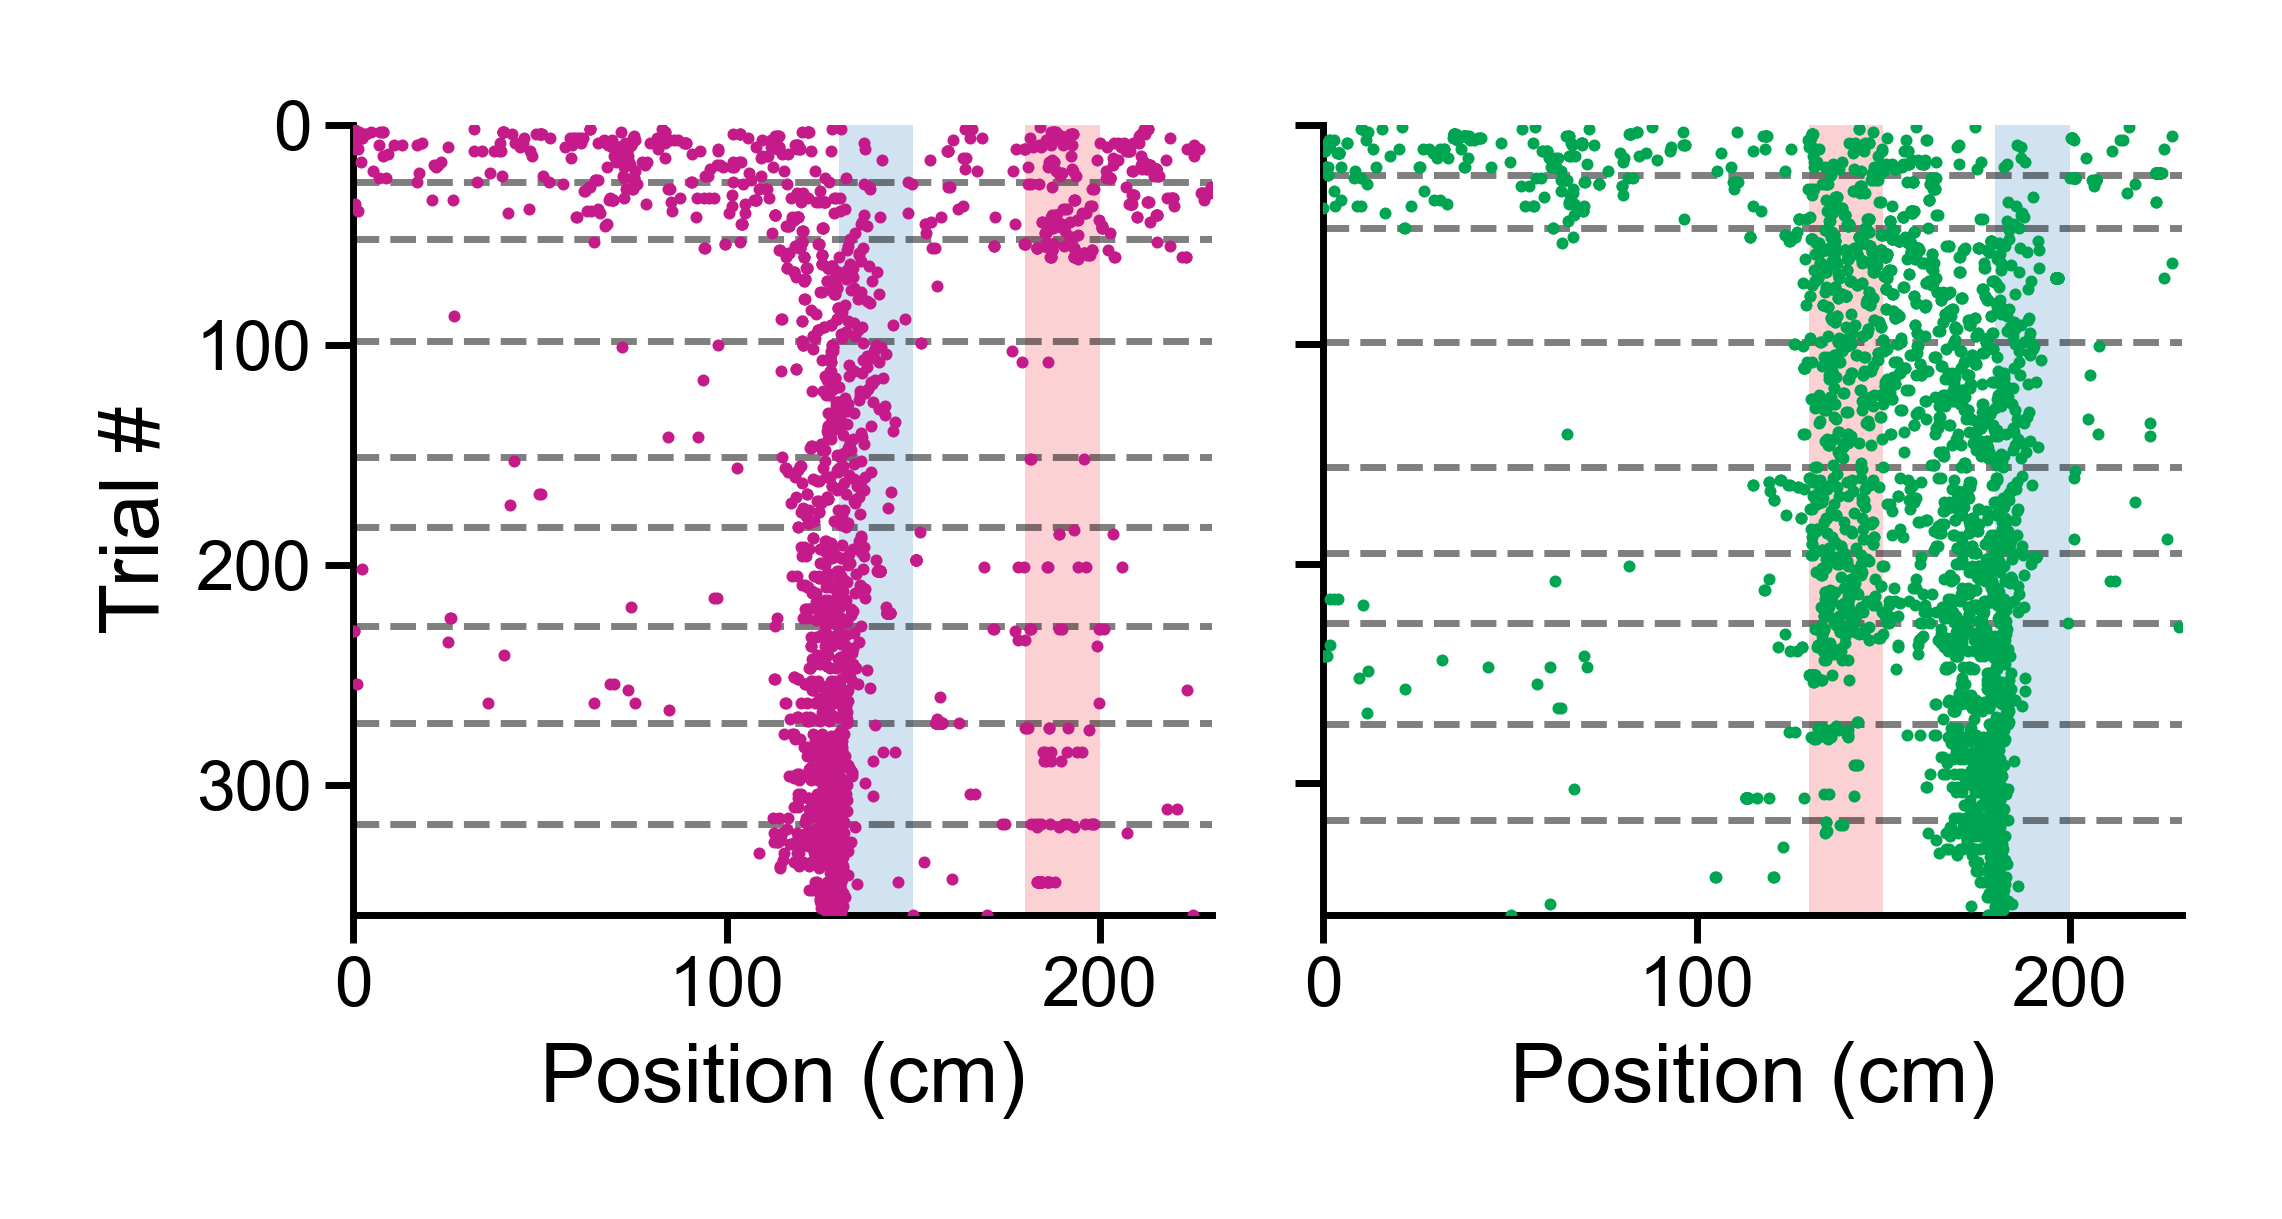

In [4]:
plt.style.use(styles('publication-tight'))
# plot
axs = plt.figure(figsize=(55/25.4 ,28/25.4),dpi=1000,layout="constrained").subplot_mosaic(
    [
        ['near','far'],
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[1,],
    # set the width ratios between the columns
    width_ratios=[1,1],
)
plot_lick_pattern(axs['near'],axs['far'], animals[2])

# plot all animals (supplemental)

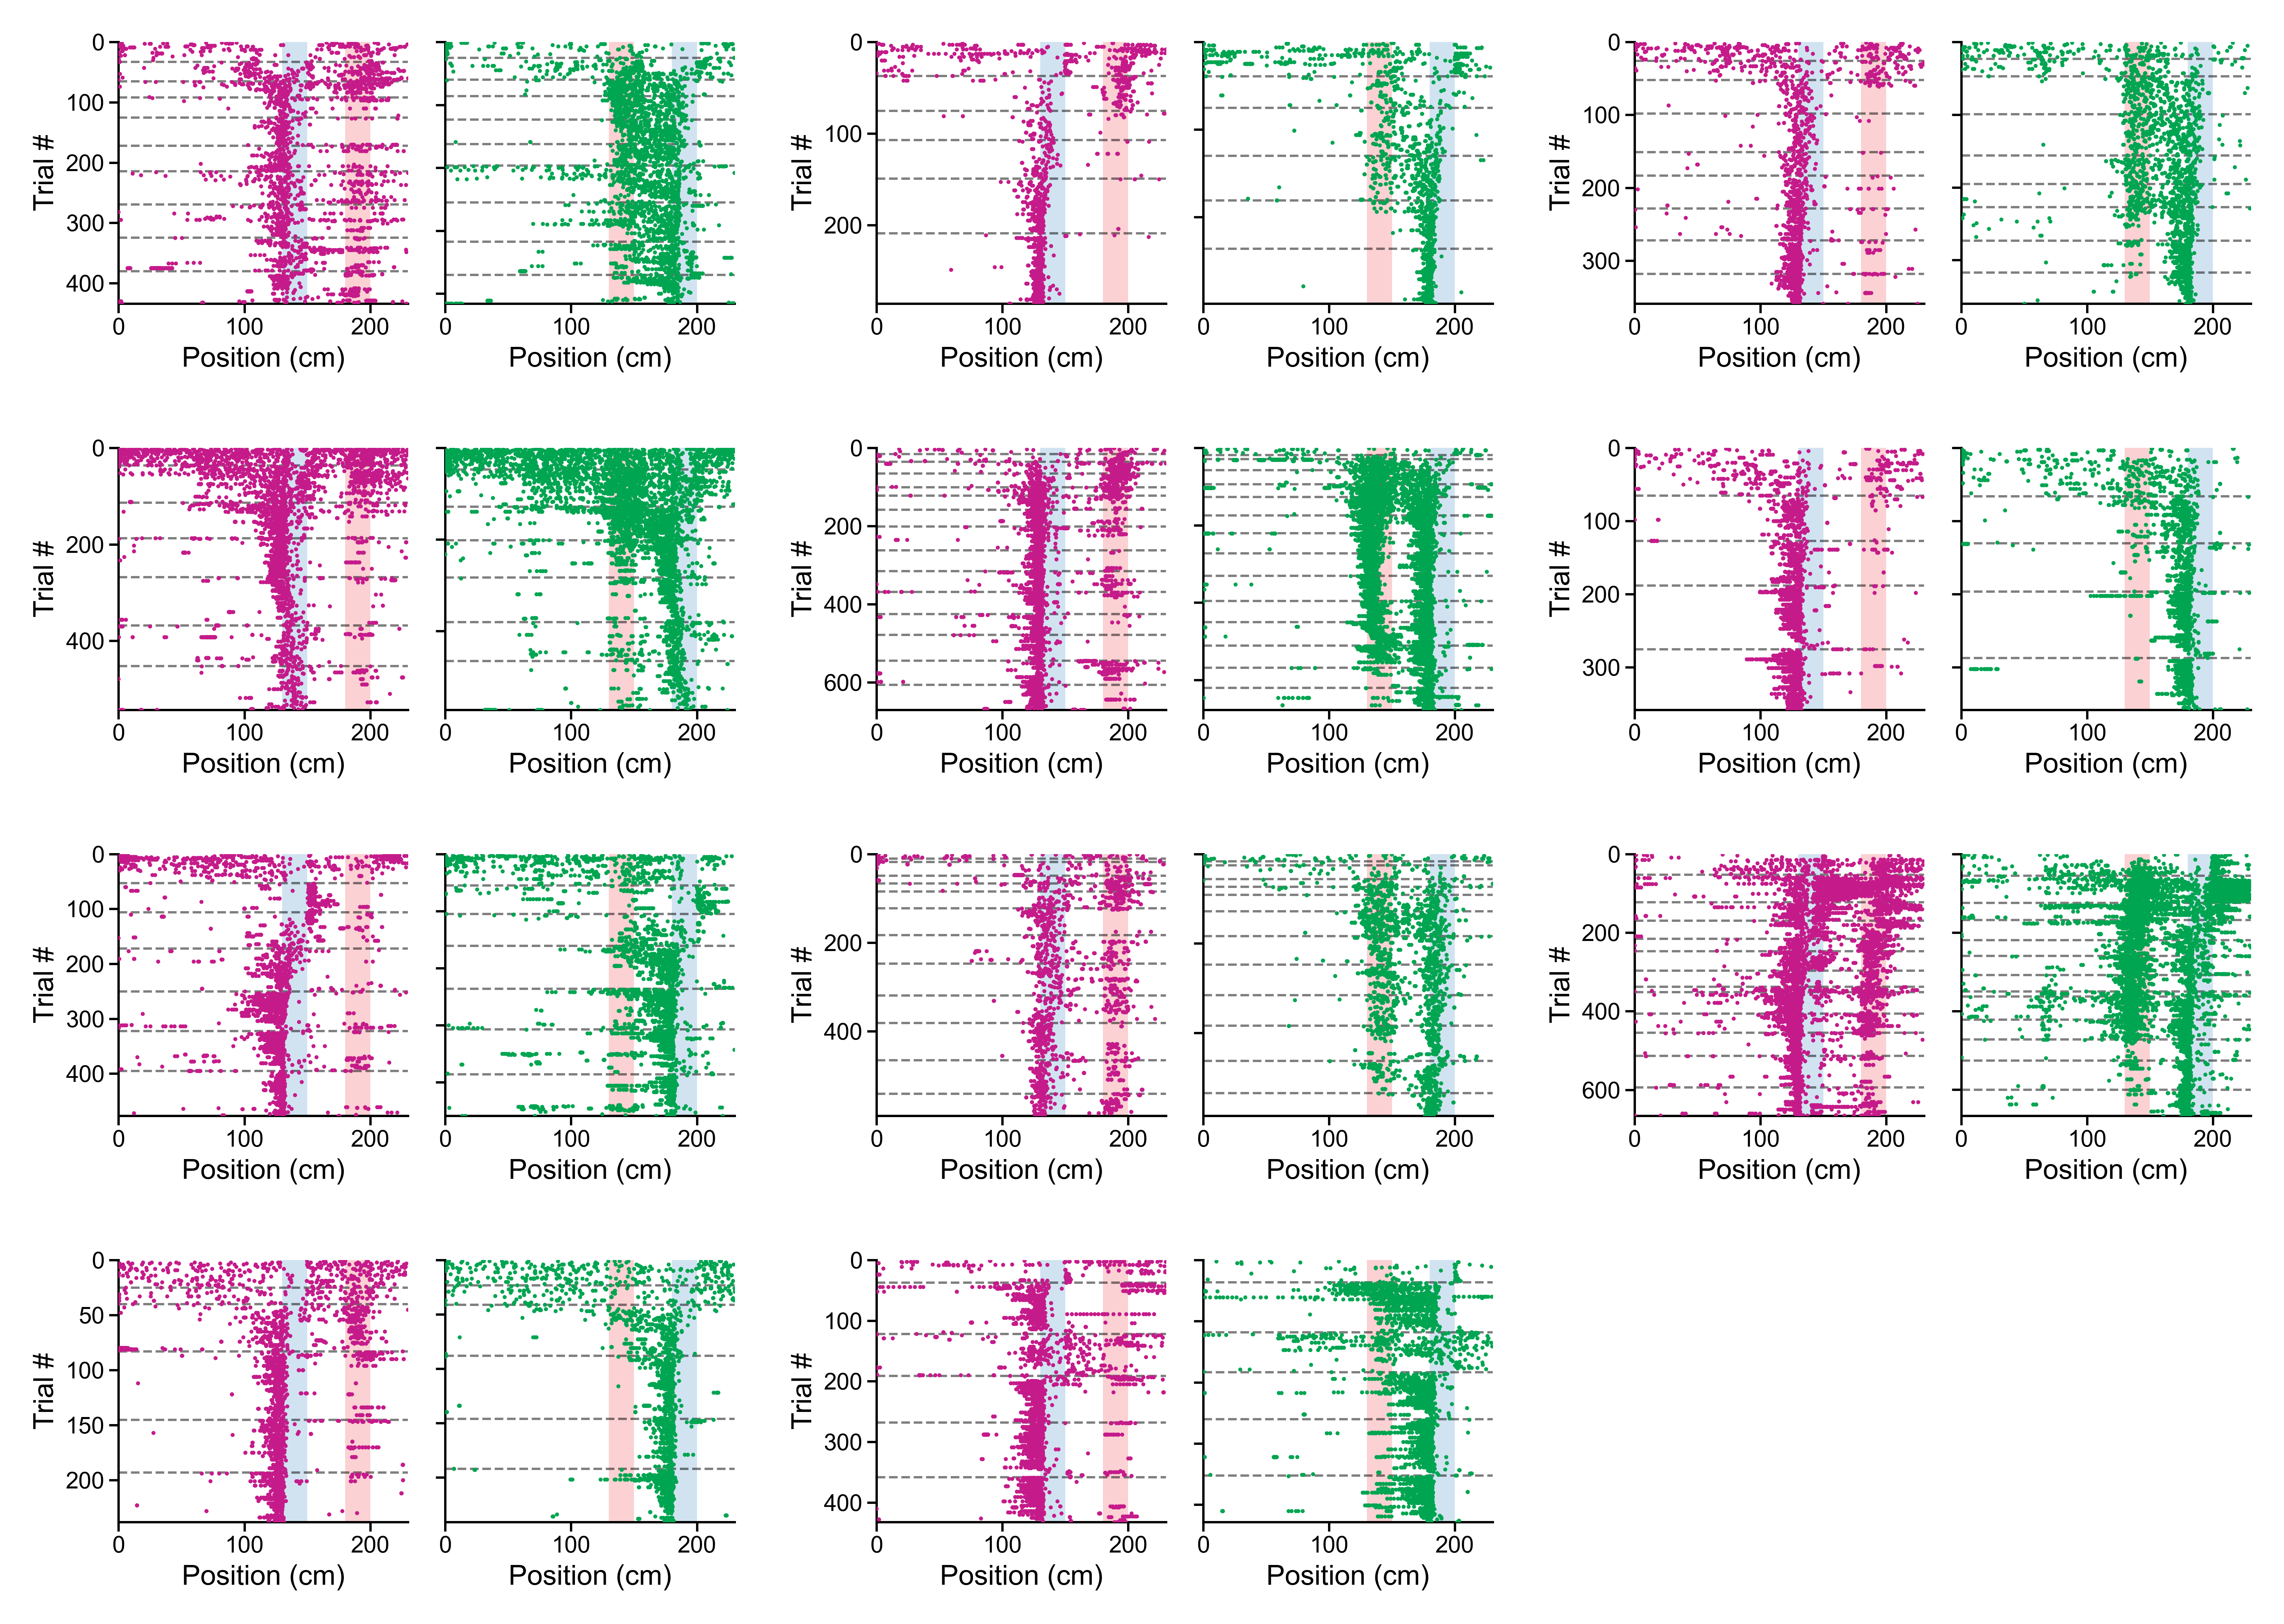

In [5]:

#animals = ['A4','A5','A7','B2','B3','B4','B5','C1','D1','F1', 'F5']
plt.style.use(styles('publication-tight'))
# plot
axs = plt.figure(figsize=(170/25.4 ,120/25.4),dpi=1000,layout="constrained").subplot_mosaic(
    [
        ['A4_near','A4_far','BLANK',   'A5_near','A5_far','BLANK',     'A7_near','A7_far'],
        ['BLANK' for i in range(8)],
        ['B2_near','B2_far','BLANK',   'B3_near','B3_far','BLANK',     'B4_near','B4_far'],
        ['BLANK' for i in range(8)],        
        ['B5_near','B5_far','BLANK',   'C1_near','C1_far','BLANK',     'D1_near','D1_far'],        
        ['BLANK' for i in range(8)],        
        ['F1_near','F1_far','BLANK',   'F5_near','F5_far','BLANK',     'BLANK','BLANK'],               
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[1,0.15,  1,0.15,  1,0.15,  1],
    # set the width ratios between the columns
    width_ratios=[1,1,0.1,  1,1,0.1,   1,1],
)
for animal in animals:
    plot_lick_pattern(axs[f'{animal}_near'],axs[f'{animal}_far'], animal)